In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import *
import itertools
from sklearn import metrics 
mpl.rcParams['font.sans-serif'] = ['SimHei']
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from pmdarima.arima import auto_arima

# autoarima模型（自动确定参数）

In [12]:
def Autoarima(train):
    try:
        model = auto_arima(train,error_action='ignore', trace=False,
                          suppress_warnings=True, maxiter=10,
                          seasonal=True, m=12)    
    except Exception as e:
        print(str(e))  
    return model


def Result(data,start,train_len,test_len):
    length = train_len+test_len
    results = []
    for i in range(0,len(data) - length+1-start):
        results.append(data[start+i:start+i+length])
        train =list( results[i][:train_len])
        test = list(results[i][train_len:])
        model = Autoarima(train)    
        pred = model.predict(test_len)       
    return pred

def Error(predict,true):
    mse = round(metrics.mean_squared_error(true, predict),4)
    rmse = round(np.sqrt(metrics.mean_squared_error(true, predict)),4)
    mae =  round(metrics.mean_absolute_error(true, predict),4)
    mape = round(np.mean(np.abs((true, predict) / np.array(true).reshape(1,len(true)))) * 100,4)
    print("误差MSE：",mse)
    print("误差RMSE：",rmse)
    print("误差MAE：",mae)
    print("误差MAPE：",mape)    
    plt.plot(predict,label="预测")
    plt.plot(true,label="真实")
    plt.xlabel(U'时间序号')
    plt.legend()
    plt.show()
    return mse,rmse,mae,mape
        
def show_all(all_data,predict_data):
    data_ = pd.Series(all_data,index = range(0,len(all_data)))
    pred_ = pd.Series(predict_data,index = range(len(all_data)-len(predict_data),len(all_data)))
    return data_,pred_
def Data_range(data,range_len):
    data.sort_values('时间')
    Time = data['时间']
    Values = data['容量']
    Values_new = []
    for i in range(0,len(data),range_len):
        values = round(np.mean(Values[i:i+range_len]),2)
        Values_new.append(values)
    return Values_new

# 磁盘数据

In [13]:
range_len = 36#粒度划分的参数
data_d = pd.read_csv('d_buquan_disk.csv')
Values_dnew = Data_range(data_d,range_len)
preds_d = Result(Values_dnew,0,len(Values_dnew)-20,20)  
data_c = pd.read_csv('c_buquan_disk.csv')
Values_cnew = Data_range(data_c,range_len)
preds_c = Result(Values_cnew,0,len(Values_cnew)-20,20)  

C磁盘ARIMA预测结果
 
误差MSE： 0.0336
误差RMSE： 0.1833
误差MAE： 0.1574
误差MAPE： 99.8957


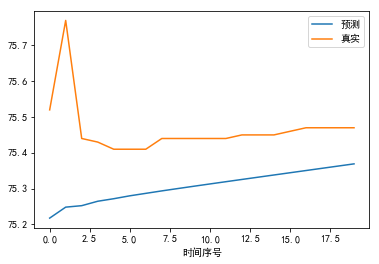

D磁盘ARIMA预测结果
 
误差MSE： 0.0075
误差RMSE： 0.0866
误差MAE： 0.0792
误差MAPE： 99.8798


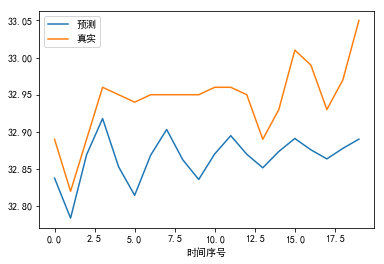

In [20]:
print("C磁盘ARIMA预测结果")
print(" ")
mse,rmse,mae,mape = Error(preds_c,Values_cnew[-20:])
print("D磁盘ARIMA预测结果")
print(" ")
mse,rmse,mae,mape = Error(preds_d,Values_dnew[-20:])

# Redis命中率数据

In [21]:
data_hit = pd.read_csv('hit_buquan_disk.csv')
Values_hit_new = Data_range(data_hit,3)
data_miss = pd.read_csv('miss_buquan_disk.csv')
Values_miss_new = Data_range(data_miss,3)
train_len = len(Values_miss_new)-20
test_len = 20
hit_rate = [b /(a+b) for a, b in zip(Values_miss_new,Values_hit_new)] 
preds_rate = Result(hit_rate,0,train_len,test_len) 

Redis命中率ARIMA预测结果
 
误差MSE： 0.0
误差RMSE： 0.003
误差MAE： 0.0027
误差MAPE： 100.1735


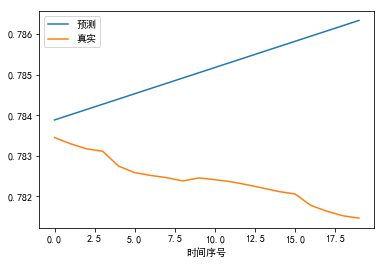

In [23]:
print("Redis命中率ARIMA预测结果")
print(" ")
mse,rmse,mae,mape = Error(preds_rate,hit_rate[-20:])

# 季节性arima模型

In [29]:
def find(train_data):
    #找出合适的参数
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
    print('Examples of parameter combinations for Seasonal ARIMA...')
    print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
    print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
    print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
    print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))
    warnings.filterwarnings("ignore")
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(train_data,order=param,seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
#确认模型以及模型的使用
def model(train_data):
    mod = sm.tsa.statespace.SARIMAX(train_data, order=(1, 1, 1),
                                    seasonal_order=(0, 1, 1, 12),
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
    results = mod.fit()
    print(results.summary().tables[1])
    results.plot_diagnostics(figsize=(15, 12))
    plt.show()
    return results
def pred_result(train_data,test_data,results):
    pred = results.get_prediction(start=len(train_data),end =len(train_data)+len(test_data)-1, dynamic=False)
    pred_ci = pred.conf_int()
    y_forecasted = pred.predicted_mean  
    plt.plot(test_data,label = '真实')
    plt.plot(y_forecasted,label = '预测')
    plt.xlabel("时间序列")
    plt.ylabel("Value")
    new_predict = y_forecasted
    plt.title("SARIMA模型预测的最后结果")
    plt.legend()
#     plt.savefig("pic/pred_miss.jpg")
    plt.show()
    print("误差MSE：",metrics.mean_squared_error(test_data, new_predict))
    print("误差RMSE：",np.sqrt(metrics.mean_squared_error(test_data, new_predict)))
    print("误差MAE：",metrics.mean_absolute_error(test_data, new_predict))
    print("误差MAPE：",(np.mean(np.abs((test_data, new_predict) / np.array(test_data).reshape(1,len(test_data)))) * 100))
    return new_predict


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4249      0.208     -2.040      0.041      -0.833      -0.017
ma.L1          0.8063      0.138      5.840      0.000       0.536       1.077
ma.S.L12      -0.7494      0.174     -4.295      0.000      -1.091      -0.407
sigma2         0.0026      0.000     12.297      0.000       0.002       0.003


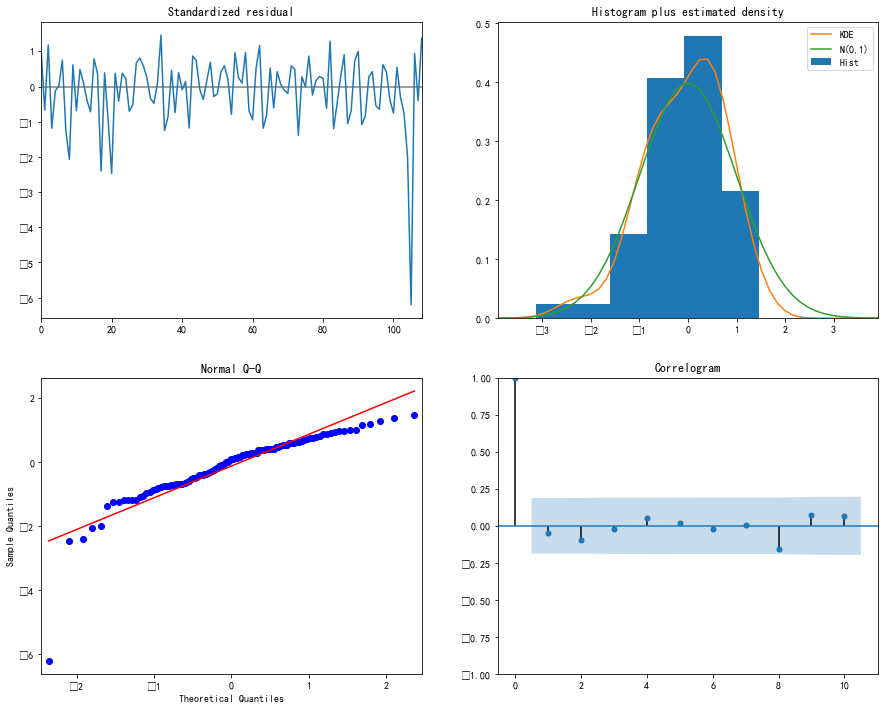

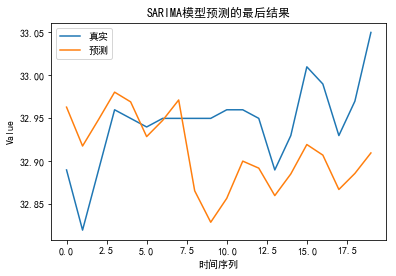

误差MSE： 0.005378351762687641
误差RMSE： 0.07333724676238972
误差MAE： 0.06324245699139652
误差MAPE： 99.94825209084645


In [30]:
data_d = pd.read_csv('d_buquan_disk.csv')
data_value = Data_range(data_d,36)
ratio = 20
train_data = data_value[:len(data_value)-ratio]
test_data = data_value[len(data_value)-ratio:]
model_res = model(train_data)
predict = pred_result(train_data,test_data,model_res)